## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [4]:
df = pd.read_csv('ab_data.csv')
df.head(7)

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1
5   936923  2017-01-10 15:20:49.083499    control     old_page          0
6   679687  2017-01-19 03:26:46.940749  treatment     new_page          1

b. Use the below cell to find the number of rows in the dataset.

In [5]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [7]:
sum(df.nunique())

585068

d. The proportion of users converted.

In [8]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [9]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [13]:
df.isnull()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [14]:
# define a new dataframe df2 from df where we excluded the 3893 records where new_page and trement didn't line up

df2 = df[((df['group']=='treatment') & (df['landing_page']=='new_page')) | ((df['group']=='control') & (df['landing_page']=='old_page'))]

In [15]:
# Double Check all of the correct rows were removed - this should be 0

df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [16]:
# No. of unique user_ids after cleaning our dataset.

df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [17]:
# display the repeated user_id

df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [18]:
df2[df2['user_id'].duplicated()]

user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [20]:
df2.drop_duplicates(subset='user_id',inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [21]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [22]:
df2.query('group =="control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [23]:
df2.query('group =="treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [24]:
len(df2[df2['landing_page'] == 'new_page'])/len(df2)

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Probability of converting given individual in a control group is 0.1203863045004612. Probability of converting given individual in a treatment group is 0.11880806551510564. According to the analysis, it is clear that there is no more conversion between new page and old page. As the converting rate is similar in both cases, it is important to consider other factors.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**If we assume that the old page is better than the new page, i.e. the new page proves to be definitely better than the old one, then the null hypotheses is that the mean converted rate of the old page is greater or equal to the converted rate of the new page and the alternative hypothesis is that the mean converted rate of the new page is greater than the converted rate of the old page.**

Null Hypotheses: $p_{old}$ is equal greater or equal to $p_{new}$

Alternative Hypothesis: $p_{old}$ is less than $p_{new}$  

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [37]:
# As per the instruction above, p_old = p_new = converted rate in ab_data.csv regardless of the page
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [38]:
# As per the instruction above, p_old = p_new = converted rate in ab_data.csv regardless of the page
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [39]:
# Create a dataframe with all new page records from df2
newPage_df = df2.query('landing_page == "new_page"')
n_new = newPage_df.shape[0]
n_new

145310

d. What is $n_{old}$?

In [40]:
# Create a dataframe with all old page records from df2

oldPage_df = df2.query('landing_page == "old_page"')
n_old = oldPage_df.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [46]:
new_page_converted = np.random.binomial(n_new,p_new)
new_page_converted

17281

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [47]:
old_page_converted = np.random.binomial(n_old,p_old)
old_page_converted

17638

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [48]:
p_diff = (new_page_converted/n_new) - (old_page_converted/n_old)
p_diff

-0.002486895810977219

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [50]:
p_diffs = []

for _ in range(10000):
    new_converted_simulation = np.random.binomial(n_new,p_new)/n_new
    old_converted_simulation = np.random.binomial(n_old,p_old)/n_old
    diff = new_converted_simulation - old_converted_simulation 
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  21.,  190.,  887., 2199., 2995., 2385., 1046.,  233.,   41.,
           3.]),
 array([-0.00433812, -0.00339106, -0.00244399, -0.00149693, -0.00054986,
         0.0003972 ,  0.00134427,  0.00229133,  0.0032384 ,  0.00418546,
         0.00513253]),
 <a list of 10 Patch objects>)

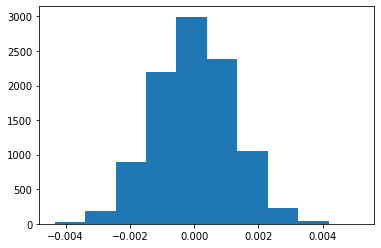

In [51]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [52]:
org_old_mean = df.query('group =="control"').converted.mean()
org_new_mean = df.query('group =="treatment"').converted.mean()
org_diff = org_new_mean - org_old_mean

# Convert p_diffs to array

p_diffs = np.array(p_diffs)

# Calculate the propotion of the p_diffs are greater than the actual difference observed in ab_data.csv
(p_diffs > org_diff).mean()

0.8868

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**In the previous part, we were calculating the p-value which is the probability of getting our statistics or a more extreme value if the null is true. Having a large p-value means that the statistics is more likely to come from our null hypothesis. Hence, there is no statistical evidence to reject the null hypothesis, which states that the old pages are the same or slightly better than the new pages.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [53]:
import statsmodels.api as sm

convert_old = sum(df2.query("group == 'control'")['converted'])
convert_new = sum(df2.query("group == 'treatment'")['converted'])
n_old = len(df2.query("group == 'control'"))
n_new = len(df2.query("group == 'treatment'"))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [55]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**z-score is less than p-value, therefore, we would fail to reject the Null hypothesis, which is consistent with the results in parts j & k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since this is a Yes-No type of variable, the appropriate approach is Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [57]:
#adding an intercept column
df2['intercept'] = 1
df2['ab_page']=0
ab_page_index = df2[df2['group']=='treatment'].index

df2.loc[ab_page_index, "ab_page"] = 1
df2.head()

user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   

   intercept  ab_page  
0          1        0  
1          1        0  
2          1        1  
3          1        1  
4          1        0

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [58]:
lm = sm.OLS(df2['converted'], df2[['intercept', 'ab_page']])
results=lm.fit()

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [59]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.719
Date:                Fri, 17 Apr 2020   Prob (F-statistic):              0.190
Time:                        16:09:52   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290582   BIC:                         1.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1204      0.001    141.407      0.000       0.119       0.122
ab_page       -0.0016      0.001     -1.311      0.190      -0.004       0.001
==============================================================================
Omnibus:                   125553.456   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414313.355
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value associated with ab_page is 0.19, it is significantly lower than the one in Part II, which was approximately 0.9. The reason for such a significant difference is because the null and alternative hypothesis differed in each exercise.

$$H_0: p_{old} - p_{new} \ge 0$$

$$H_1: p_{old} - p_{new} \lt; 0$$
$$H_0: p_{old} = p_{new}$$

$$H_1: p_{old} \ne p_{new}$$
$p_{old}$ and $p_{new}$ are the converted rates for the old and new pages respectively.

Because the later case relies solely on two possible outcomes, it may be the reason that it yields a lower probability in the null hypothesis than that in the case in Part II of the earlier exercise.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Considering other factors is a good idea as these factors may contribute to more significant test results and leads to more accurate decisions. One of the disadvantages of adding additional terms into the regression model is Simpson's paradox where the combined impact of different variables disappears or gets reversed when these variables are combined, but appears when these variables are tested individually.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [65]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  intercept  ab_page  
user_id                                 
834778           0          1        0  
928468           0          1        1  
822059           1          1        1  
711597           0          1        0  
710616           0          1        1

In [66]:
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [67]:
#Adding dummy 

df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  intercept  ab_page  CA  UK  US  
user_id                                             
834778           0          1        0   0   1   0  
928468           0          1        1   0   0   1  
822059           1          1        1   0   1   0  
711597           0          1        0   0   1   0  
710616           0          1        1   0   1   0

In [68]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 17 Apr 2020   Pseudo R-squ.:               1.521e-05
Time:                        16:31:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

Results: Once again, the p-values for hte countries are well above 0.05 $\alpha$ level. So we fail to reject the null, there is no significant contribution from country to make a differences in conversion rates for the two pages.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [69]:
df_new['CA_page'] = df_new['CA'] * df_new['ab_page']
df_new['UK_page'] = df_new['UK'] * df_new['ab_page']
df_new.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  intercept  ab_page  CA  UK  US  CA_page  UK_page  
user_id                                                               
834778           0          1        0   0   1   0        0        0  
928468           0          1        1   0   0   1        0        0  
822059           1          1        1   0   1   0        0        1  
711597           0          1        0   0   1   0        0        0  
710616           0          1        1   0   1   0        0        1

In [70]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK', 'CA_page', 'UK_page']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 17 Apr 2020   Pseudo R-squ.:               3.482e-05
Time:                        16:33:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

>The p-value for ab_page is 0.132.

>The null hypothesis was that the difference in means would be 0, and the alternative was the difference would be greater or less than 0. The p-value is still large. We fail to reject the null hypothesis.

<a id='conclusions'></a>
## Conclusions

>None of the variables have significant p-values. Therefore, we fail to reject the null hypothesis and conclude that there just isn't a sufficient evidence to suggest that there is an interaction between country and page received, that will predict whether a user converts or not.

>In the larger picture, based on the available information, we do not have sufficient evidence to suggest that the new page results in more conversions than the old page.